# CMPE - Building a novel Re-sampling method for Imbalanced Network Traffic Dataset

## 1. Data Preprocessing

### 1.1 Overview

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# UNSW-NB15 Data
df_1 = pd.read_csv('/content/drive/MyDrive/data_chunks/UNSW-NB15_1.csv')
df_2 = pd.read_csv('/content/drive/MyDrive/data_chunks/UNSW-NB15_2.csv')
df_3 = pd.read_csv('/content/drive/MyDrive/data_chunks/UNSW-NB15_3.csv')
df_4 = pd.read_csv('/content/drive/MyDrive/data_chunks/UNSW-NB15_4.csv')


In [ ]:
df = pd.concat([df_1, df_2, df_3, df_3, df_4])
df.head()

,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [ ]:
df.shape

(3240048, 49)

In [ ]:
# Turn all column names to lower case
df.columns = df.columns.str.lower()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240048 entries, 0 to 440043
Data columns (total 49 columns):
 #   Column            Dtype  
---  ------            -----  
 0   srcip             object 
 1   sport             object 
 2   dstip             object 
 3   dsport            object 
 4   proto             object 
 5   state             object 
 6   dur               float64
 7   sbytes            int64  
 8   dbytes            int64  
 9   sttl              int64  
 10  dttl              int64  
 11  sloss             int64  
 12  dloss             int64  
 13  service           object 
 14  sload             float64
 15  dload             float64
 16  spkts             int64  
 17  dpkts             int64  
 18  swin              int64  
 19  dwin              int64  
 20  stcpb             int64  
 21  dtcpb             int64  
 22  smeansz           int64  
 23  dmeansz           int64  
 24  trans_depth       int64  
 25  res_bdy_len       int64  
 26  sjit           

In [ ]:
df.isnull().sum()

srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports     

In [ ]:
# clean up each attack category cell
def clean_up_cat(attack_cat):
  if isinstance(attack_cat, str): 
    return attack_cat.strip()

  return attack_cat

df['attack_cat'] = df['attack_cat'].apply(clean_up_cat)

# Get all attack categories & labels:
print(df['attack_cat'].unique())
print(df['label'].unique())


[nan 'Exploits' 'Reconnaissance' 'DoS' 'Generic' 'Shellcode' 'Fuzzers'
 'Worms' 'Backdoors' 'Analysis' 'Backdoor']
[0 1]


### 1.2. Network traffic distribution

478708 of 3240048 network flows are attacks and it is the 14.77% of the data set.
2761340 of 3240048 network flows are normal and it is the 85.23% of the data set.


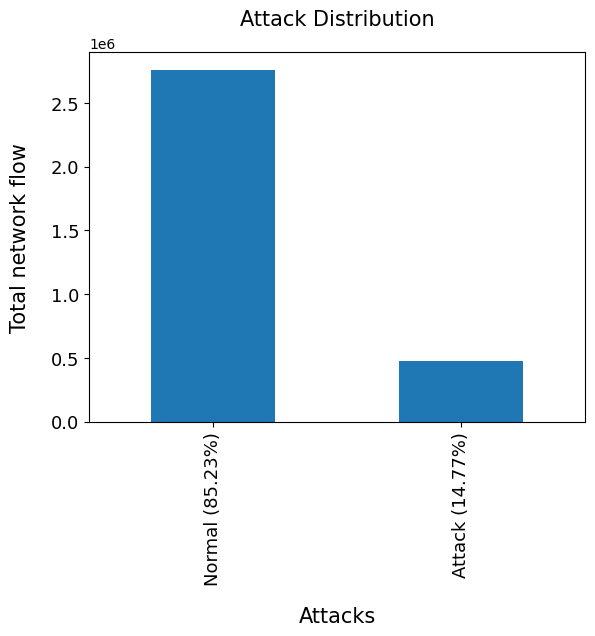

In [ ]:
# attacks vs normal
attack = df['label'].value_counts()[1]
normal = df['label'].value_counts()[0]
attack_per = attack / df.shape[0] * 100
normal_per = normal / df.shape[0] * 100

print('{} of {} network flows are attacks and it is the {:.2f}% of the data set.'.format(attack, df.shape[0], attack_per))
print('{} of {} network flows are normal and it is the {:.2f}% of the data set.'.format(normal, df.shape[0], normal_per))


# count the occurrences of each unique value in the 'name' column
counts = df['label'].value_counts()

# plot the result as a bar plot
counts.plot(kind='bar')

# set x and y labels and a title for the plot
plt.xlabel('Attacks', size=15, labelpad=15)
plt.ylabel('Total network flow', size=15, labelpad=15)
plt.xticks((0, 1), ['Normal ({0:.2f}%)'.format(normal_per), 'Attack ({0:.2f}%)'.format(attack_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Attack Distribution', size=15, y=1.05)

# display the plot
plt.show()


### 1.2. All network categories distribution

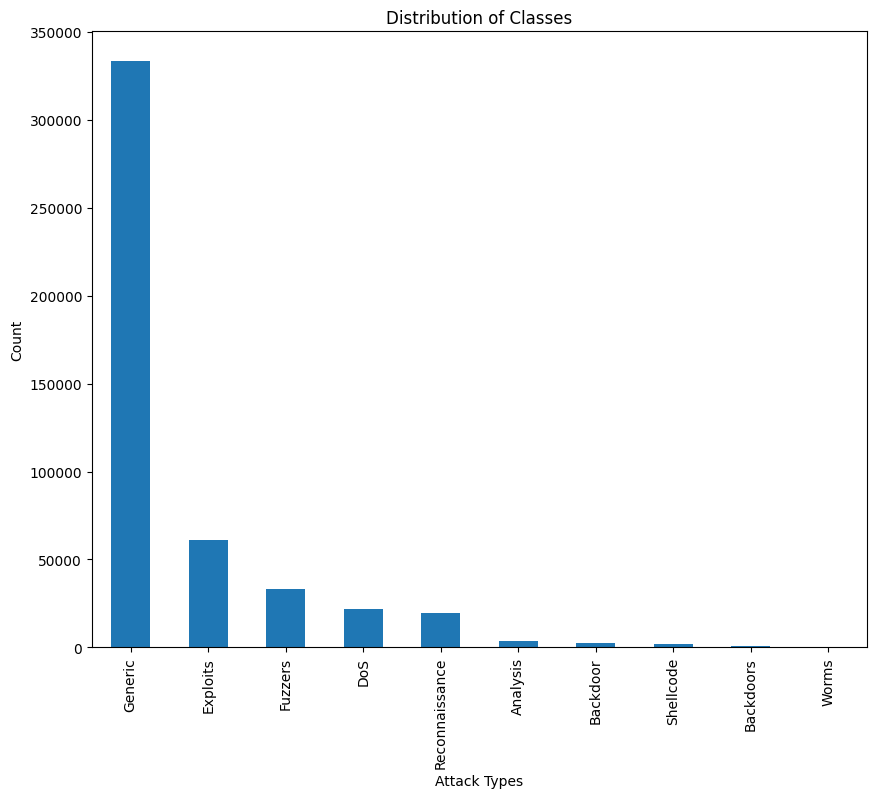

In [ ]:
# all attack categories

attack_categories = df['attack_cat'].value_counts()

# Create a new figure with a custom size
plt.figure(figsize=(10, 8))

attack_categories.plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Attack Types')
plt.ylabel('Count')
plt.show()

### 1.3. Distribution of IP addresses with respect to each attack category

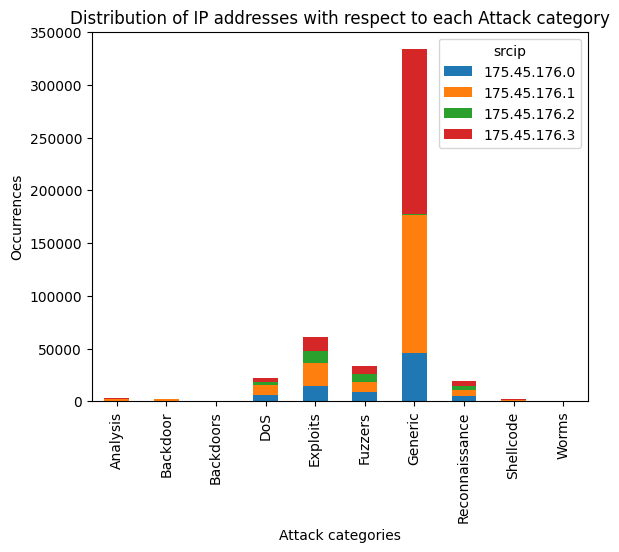

In [ ]:
# Group the data by the attack_cat column and srcip column, and count the number of occurrences of each value
grouped_data = df.groupby(['attack_cat', 'srcip']).size().unstack()

# Normalize the counts to percentages
# grouped_data = df.div(grouped_data.sum(axis=1), axis=0)

# Plot the grouped data as a stacked bar plot
grouped_data.plot(kind='bar', stacked=True)
plt.title('Distribution of IP addresses with respect to each Attack category')
plt.xlabel('Attack categories')
plt.ylabel('Occurrences')
plt.show()



Check whether the four ip addresses above were used to generative malicious samples while not being used to generate benign samples -> obviously this never occurs in real world

In [ ]:
# Check if the set of IP addresses exists in benign sample
ip_addresses = ['175.45.176.0', '175.45.176.1', '175.45.176.2', '175.45.176.3']

is_in_category_b = df[df['label'] == 0]['srcip'].isin(ip_addresses).any()

# Print the result
print(is_in_category_b)

True


Ip Addresses are not reliable when used to generate samples, especially if they are also used to generate benign samples.


1.   Dynamic IP Addresses: Many internet service providers (ISPs) use dynamic IP addresses, which means that a single IP address may be assigned to multiple users over time. If the IP address used to generate malicious samples is reassigned to a benign user at a later time, it can create false positives in the detection process.
2.   Spoofed IP Addresses: Attackers can also spoof IP addresses, which means that they can make it appear as if the attack is coming from a different IP address than the one they are actually using. This can make it difficult to accurately attribute attacks to specific IP addresses.
3. IP Address Reputation: Many organizations use IP address reputation lists to block traffic from known malicious sources. If an IP address that was previously used to generate malicious samples is later used to generate benign samples, it can negatively impact its reputation and result in benign traffic being blocked.



### 1.4 Distribution of IP adresses with respect to network type ( attack or benign)

In [ ]:
# Interactive plot:
import plotly.graph_objects as go

# Group the data by the attack_cat column and srcip column, and count the number of occurrences of each value
grouped_data = df.groupby(['label', 'srcip']).size().unstack()

# Create a list of traces for the plot
traces = []
for i, col in enumerate(grouped_data.columns):
    trace = go.Bar(x=grouped_data.index, y=grouped_data[col], name=col)
    traces.append(trace)

# Create the layout for the plot
# Create the layout for the plot
layout = go.Layout(
    title='Distribution of IP addresses with respect to each network type',
    xaxis=dict(title='Network Type'),
    yaxis=dict(title='Occurrences'),
    barmode='stack')

# Create the figure object and add the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


Since there is no insight can be drawn from network IP addresses, we can go ahead and ommit this feature

### 1.5. Distribution of transaction protocol with respect to each attack type

In [ ]:

# Group the data by the attack_cat column and srcip column, and count the number of occurrences of each value
grouped_data = df.groupby(['attack_cat', 'proto']).size().unstack()

# Create a list of traces for the plot
traces = []
for i, col in enumerate(grouped_data.columns):
    trace = go.Bar(x=grouped_data.index, y=grouped_data[col], name=col)
    traces.append(trace)

# Create the layout for the plot
# Create the layout for the plot
layout = go.Layout(
    title='Distribution of IP addresses with respect to each Attack category',
    xaxis=dict(title='Attack categories'),
    yaxis=dict(title='Occurrences'),
    barmode='stack')

# Create the figure object and add the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


### 1.6. Distribution of transaction protocol with respect to each network type

In [ ]:

# Group the data by the attack_cat column and srcip column, and count the number of occurrences of each value
grouped_data = df.groupby(['label', 'proto']).size().unstack()

# Create a list of traces for the plot
traces = []
for i, col in enumerate(grouped_data.columns):
    trace = go.Bar(x=grouped_data.index, y=grouped_data[col], name=col)
    traces.append(trace)

# Create the layout for the plot
# Create the layout for the plot
layout = go.Layout(
    title='Distribution of transaction protocol with respect to each network type',
    xaxis=dict(title='Network types'),
    yaxis=dict(title='Occurrences'),
    barmode='stack')

# Create the figure object and add the traces and layout
fig = go.Figure(data=traces, layout=layout)

# Show the figure
fig.show()


Since there is no insight can be drawn from network transaction protocol, we can go ahead and ommit this feature

### 1.7. Feature Correlation

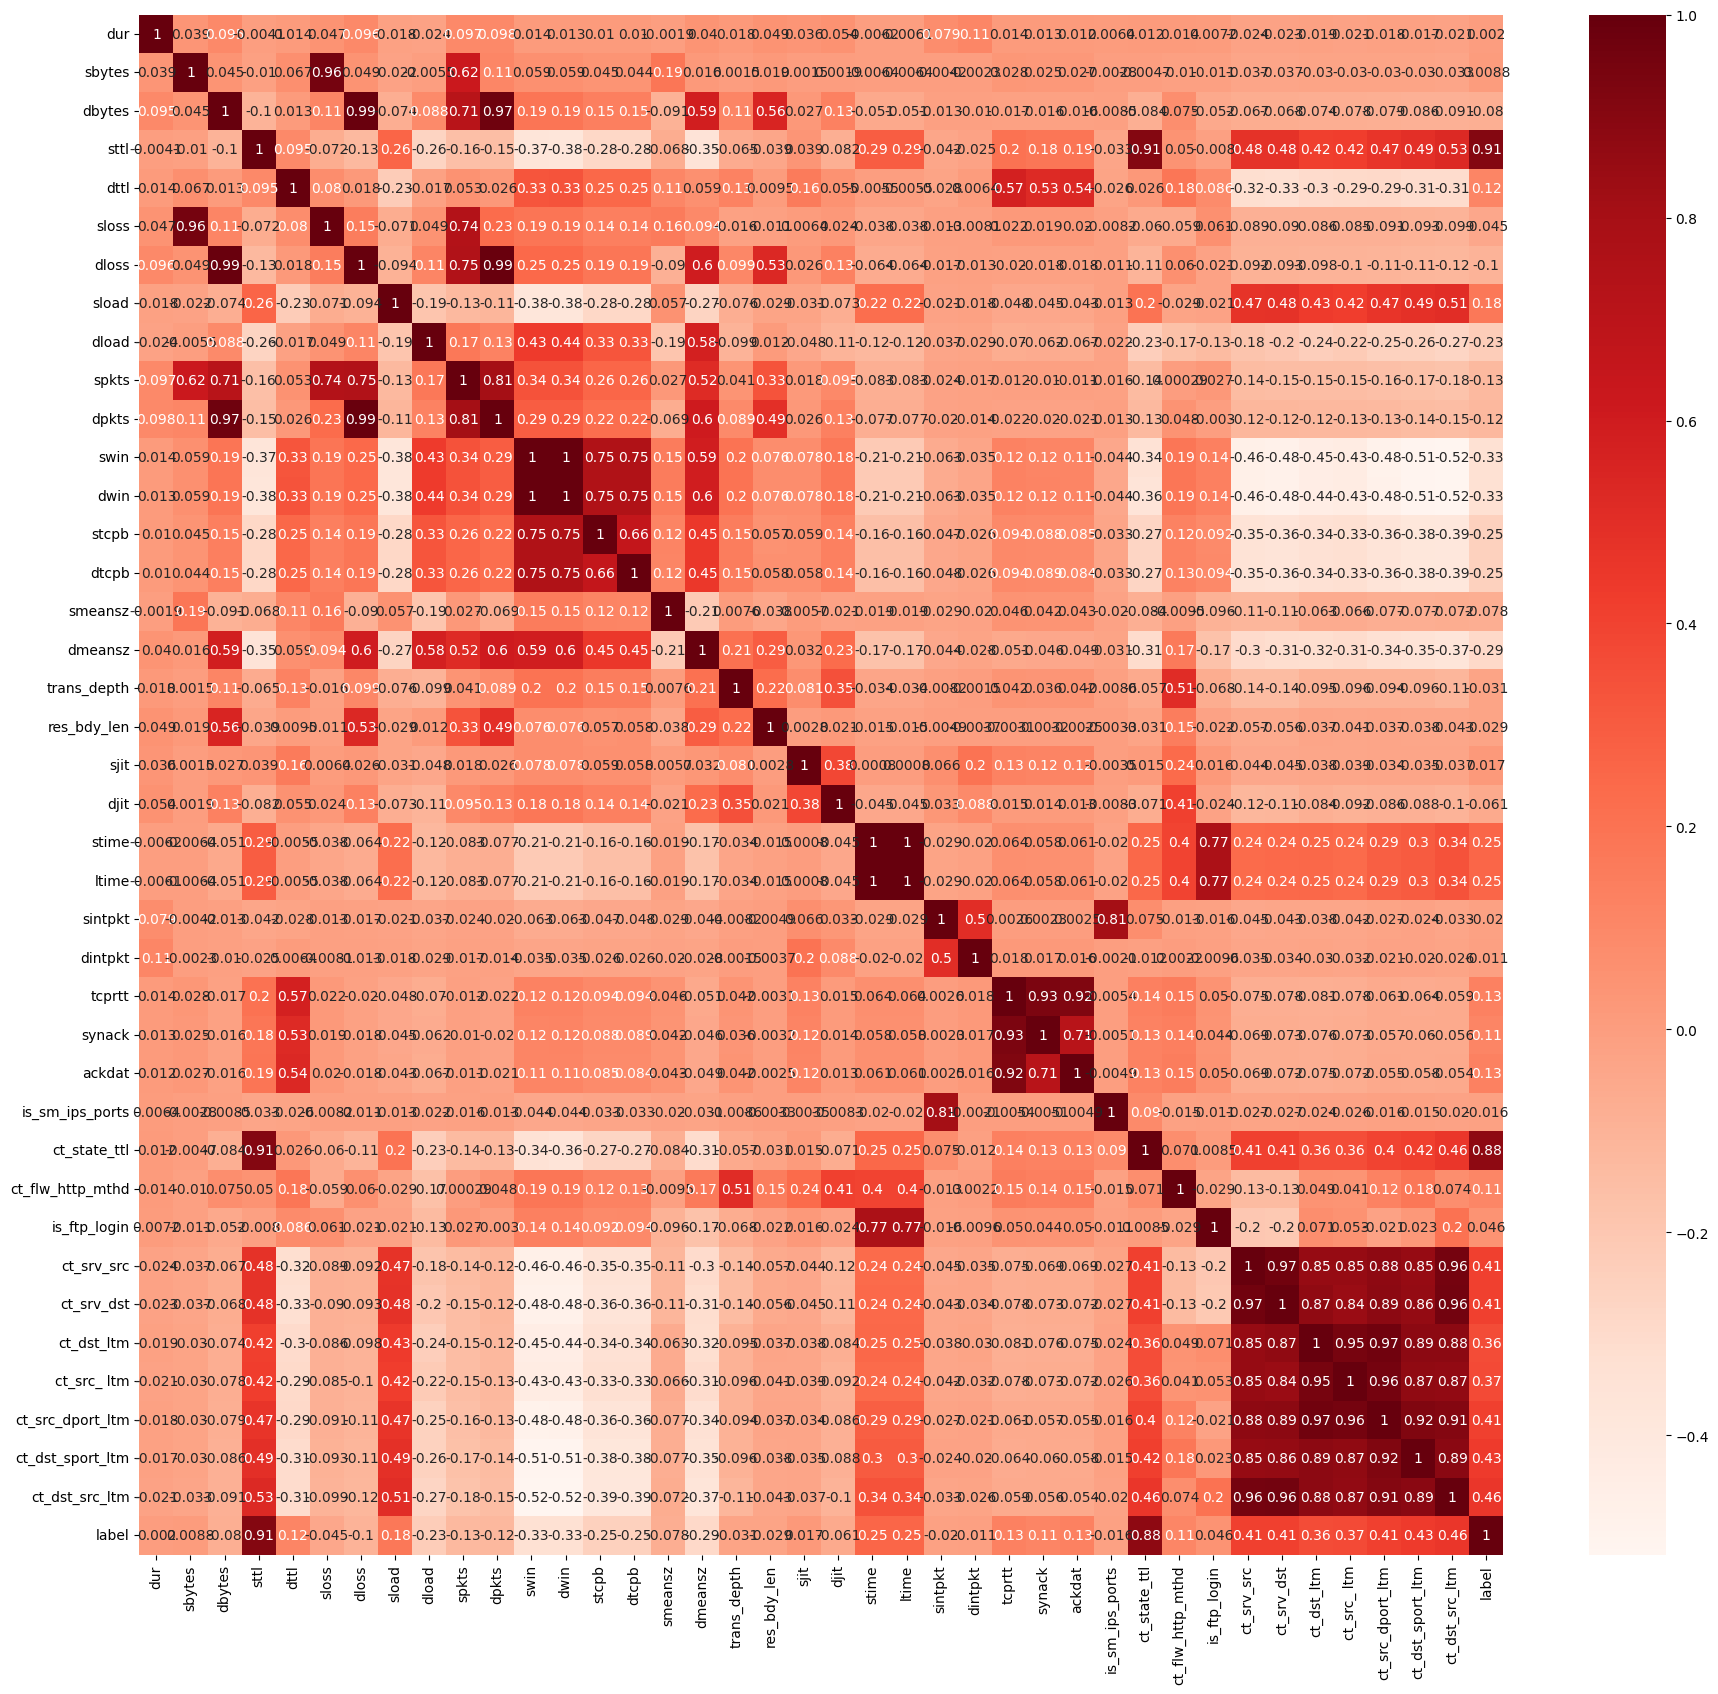

In [ ]:
# Visualize Correlation between Columns
plt.figure(figsize=(22,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Look at the ct_state_ttl, sttl features (too high value) -> can just use these values to get high result (may remove them)

## 2. Feature Engineering

### 2.1 Removing irrelevant features

In [ ]:
drop_cols = ['dstip', 'srcip', 'sport', 'dsport', 'state',  'ct_ftp_cmd', 'ct_ftp_cmd', 'ct_dst_src_ltm',
             'is_sm_ips_ports', 'stime', 'state', 'ltime', 'service', 'dbytes', 'dur', 'djit', 'state', 'proto',
             'ct_flw_http_mthd', 'is_ftp_login'
            #  'ct_state_ttl', 'sttl'
             ]

df.drop(columns=drop_cols, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240048 entries, 0 to 440043
Data columns (total 32 columns):
 #   Column            Dtype  
---  ------            -----  
 0   sbytes            int64  
 1   sttl              int64  
 2   dttl              int64  
 3   sloss             int64  
 4   dloss             int64  
 5   sload             float64
 6   dload             float64
 7   spkts             int64  
 8   dpkts             int64  
 9   swin              int64  
 10  dwin              int64  
 11  stcpb             int64  
 12  dtcpb             int64  
 13  smeansz           int64  
 14  dmeansz           int64  
 15  trans_depth       int64  
 16  res_bdy_len       int64  
 17  sjit              float64
 18  sintpkt           float64
 19  dintpkt           float64
 20  tcprtt            float64
 21  synack            float64
 22  ackdat            float64
 23  ct_state_ttl      int64  
 24  ct_srv_src        int64  
 25  ct_srv_dst        int64  
 26  ct_dst_ltm     

In [ ]:
df.isnull().sum()

sbytes                    0
dttl                      0
sloss                     0
dloss                     0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
ct_srv_src                0
ct_srv_dst                0
ct_dst_ltm                0
ct_src_ ltm               0
ct_src_dport_ltm          0
ct_dst_sport_ltm          0
attack_cat          2761340
label                     0
dtype: int64

### 2.2 Encoding attack category 

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Fill NaN values with a placeholder value
df['attack_cat'].fillna(value='nan', inplace=True)
attack_cat = df['attack_cat']

# Initialize a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to the attack category feature and transform the feature
attack_cat_encoded = le.fit_transform(attack_cat)

# Replace the original attack category feature with the encoded feature
df['encoded_attack_cat'] = attack_cat_encoded

print(df['encoded_attack_cat'].unique())

[10  4  7  3  6  8  5  9  2  0  1]


### 2.3 Rerun the same heat map for attack categories

Making sure if there isn't any highly correlated feature

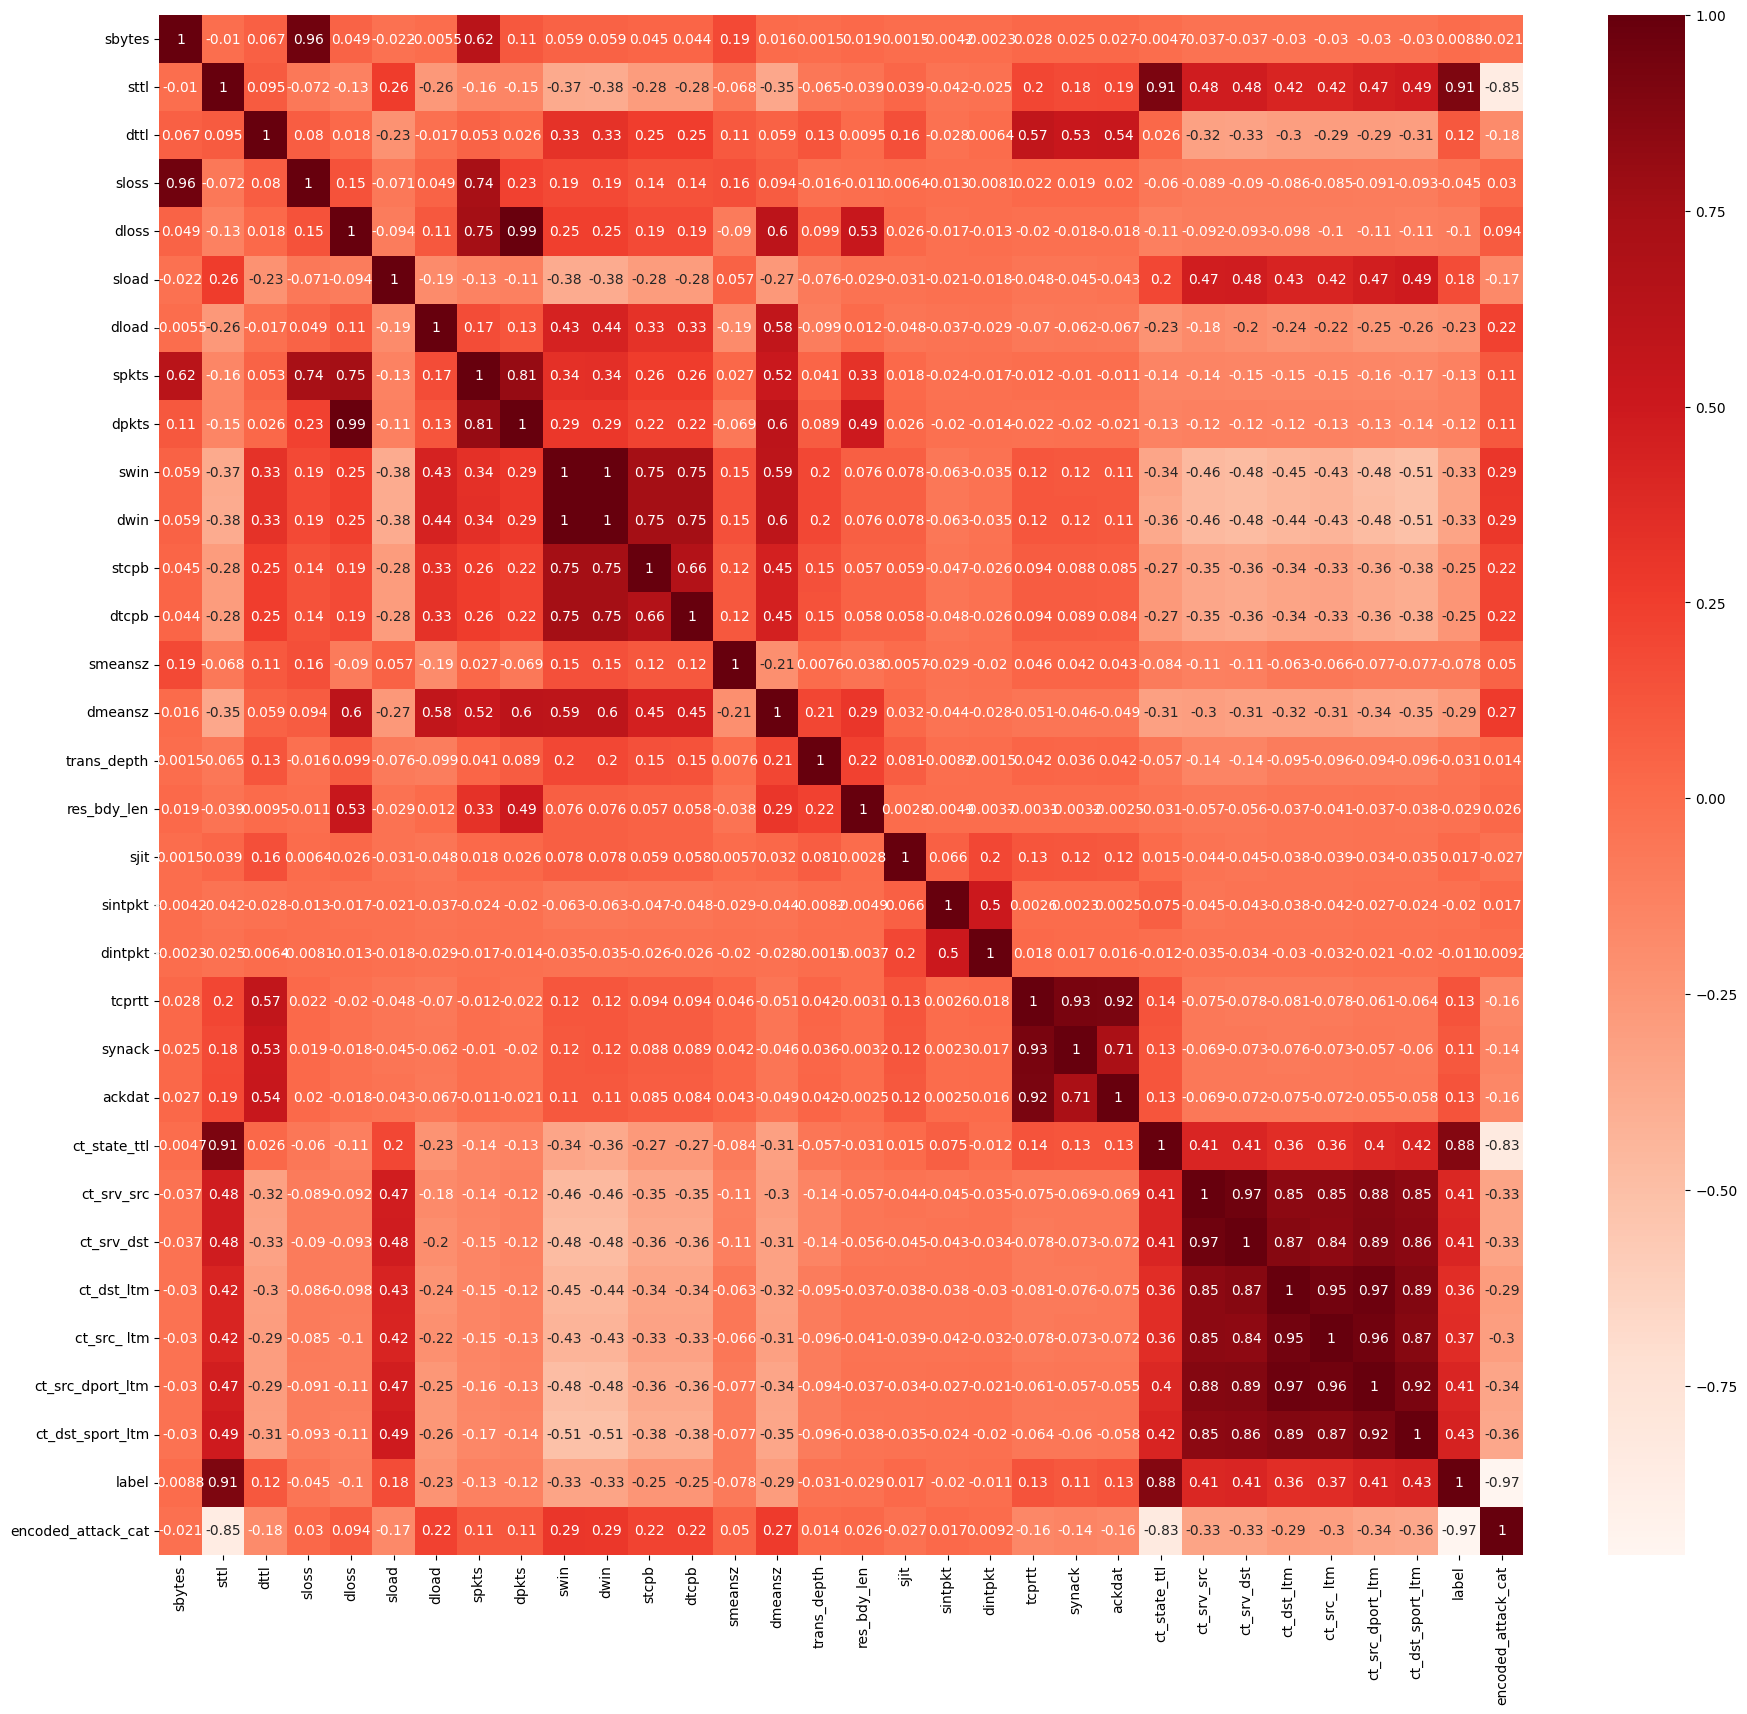

In [ ]:
# Visualize Correlation between Columns
plt.figure(figsize=(22,20))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

## 3. Building classification models before re-sampling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, matthews_corrcoef

# temporary solution - dropping attack_cat columns for now
# Separate the features and target variable
X = df.drop(['label', 'attack_cat', 'encoded_attack_cat'], axis=1)
y = df['label']
columns = X.columns

scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### 3.1 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

dt_pred = dt_model.predict(X_test)

print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552428
           1       0.98      0.98      0.98     95582

    accuracy                           1.00    648010
   macro avg       0.99      0.99      0.99    648010
weighted avg       1.00      1.00      1.00    648010



#### Explainable model for the Decision tree model

In [ ]:
!pip install lime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=71201d28c6ef5e175cdb7578011f444991b83e5ebb958220418969051cd2e4bf
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


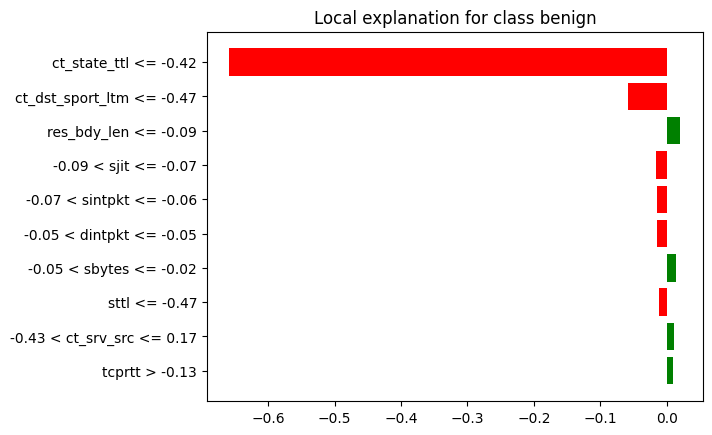

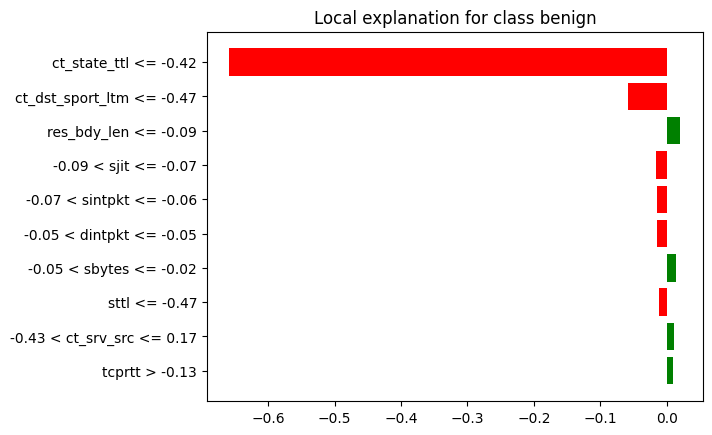

In [ ]:
# LIME
import lime
import lime.lime_tabular

# create a LIME explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(X_train,
                                                   feature_names=columns,
                                                   class_names=['attack', 'benign'],
                                                   discretize_continuous=True)

# select a random instance from the test set to explain
instance = X_test[0]

# generate an explanation for the instance
explanation = explainer.explain_instance(instance, dt_model.predict_proba)

# plot the explanation
explanation.as_pyplot_figure()


In [ ]:
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 21.5 MB/s eta 0:00:00


In [ ]:
# SHAP

import shap

# create a SHAP explainer object
explainer = shap.TreeExplainer(dt_model)

# calculate SHAP values for a set of instances
shap_values = explainer.shap_values(X_test)

# summarize the feature importance of the instances
shap.summary_plot(shap_values[1], X_test, plot_type="bar")


AUC score: 0.9919886722933877


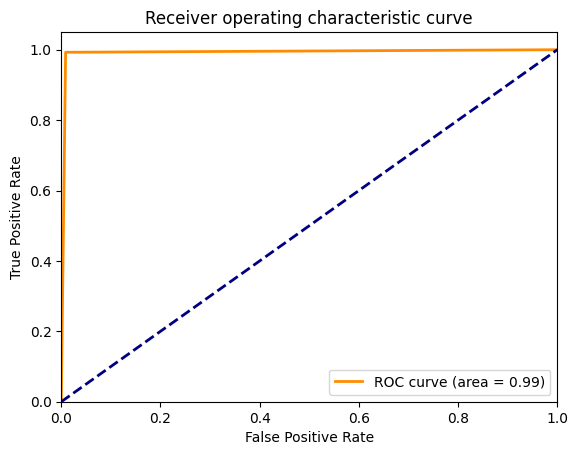

In [ ]:
# validate Ml model:

# AUC
from sklearn.metrics import roc_auc_score, roc_curve, auc

auc_score = roc_auc_score(y_test,dt_pred)

print('AUC score:', auc_score)

# y_test and y_score are the true labels and predicted scores, respectively
fpr, tpr, _ = roc_curve(y_test, dt_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# K-fold Cross Validation
from sklearn.model_selection import KFold, cross_val_score

# Define the k-fold cross-validation method
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Evaluate the model using cross-validation
dt_model=DecisionTreeClassifier()
scores = cross_val_score(dt_model, X_train, y_train, cv=kfold, scoring='roc_auc')

# Print the AUC scores for each fold
print('AUC Scores:', scores)

# Calculate the mean AUC score and standard deviation
mean_auc = scores.mean()
std_auc = scores.std()

# Fit the model to the full training set and calculate AUC on the test set
dt_model.fit(X_train, y_train)
y_pred = dt_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, y_pred)

# Print the mean AUC score and test AUC score
print('Mean AUC:', mean_auc)
print('Test AUC:', test_auc)

AUC Scores: [0.99128179 0.99180641 0.99166247 0.99179738 0.99206999 0.99201215
 0.99181372 0.99210367 0.99186124 0.99197694]
Mean AUC: 0.9918385778513235
Test AUC: 0.9922689508788134


### 3.2 SVM

## 4. Re-sampling the dataset

### 4.1 Under sampling

In [ ]:
from sklearn.utils import resample

# # temporary solution - dropping attack_cat columns for now
# # Separate the features and target variable
# X = df.drop(['label', 'attack_cat'], axis=1)
# y = df['label']

# Combine the features and target variable
combined_data = np.column_stack((X, y))

# Separate the majority and minority class
majority_class = combined_data[combined_data[:, -1] == 0]
minority_class = combined_data[combined_data[:, -1] == 1]

# Downsample the majority class
majority_downsampled = resample(majority_class, 
                                 replace=False, 
                                 n_samples=len(minority_class), 
                                 random_state=42)

# Combine the majority_downsampled and minority_class
downsampled_data = np.vstack((majority_downsampled, minority_class))

# Separate the features and target variable from the downsampled data
X_resampled = downsampled_data[:, :-1]
y_resampled = downsampled_data[:, -1]

# Print the number of observations before and after under-sampling
print("Original dataset shape:", X.shape, y.shape)
print("Resampled dataset shape:", X_resampled.shape, y_resampled.shape)


Original dataset shape: (3240048, 30) (3240048,)
Resampled dataset shape: (957416, 30) (957416,)


#### Evaluation

Check the new distribution of classes to ensure that the technique has effectively reduced the class imbalance

In [ ]:
unique_classes, class_counts = np.unique(y_resampled, return_counts=True)

for cls, count in zip(unique_classes, class_counts):
    print(f"Class {cls}: {count} samples")

Class 0.0: 478708 samples
Class 1.0: 478708 samples


Check feature correlations matrix to ensure down sampling is correct

In [ ]:
# Visualize Correlation between Columns
plt.figure(figsize=(22,20))
cor = X_resampled.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

AttributeError: ignored

<Figure size 2200x2000 with 0 Axes>

## 5. Building classification models after re-sampling

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, matthews_corrcoef


scaler = StandardScaler()
X_resampled = scaler.fit_transform(X_resampled)

# Split the data into training, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)





### 5.1 Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

dt_pred = dt_model.predict(X_test)

print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     95714
         1.0       0.99      0.99      0.99     95770

    accuracy                           0.99    191484
   macro avg       0.99      0.99      0.99    191484
weighted avg       0.99      0.99      0.99    191484



In [ ]:
# Validating machine learning model

#AUC






### 5.2 SVM

In [ ]:
# from sklearn.svm import SVC

# svc=SVC(kernel='linear') # kernel = 'rbf' # poly
# svc.fit(X_train,y_train)
# y_pred=svc.predict(X_test)
# print('Accuracy Score:')
# print(accuracy_score(y_test,y_pred))

### 5.3 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf= RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train,y_train)

rf_pre=rf.predict(X_test)

print(classification_report(y_test,rf_pre))

### 5.4 Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Instantiate Logistic Regression model
lr = LogisticRegression(solver='liblinear', random_state=42)

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
lr_pre = lr.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, lr_pre)
print('Accuracy:', accuracy)

print(classification_report(y_test,lr_pre))

## 6. New dataset

### 6.1 Initial exploration

In [ ]:
# CICDIDS2018 datasets
# ids_df_1 = pd.read_csv('/content/drive/MyDrive/IDS2018/02-14-2018.csv')
# ids_df_2 = pd.read_csv('/content/drive/MyDrive/IDS2018/02-15-2018.csv')
# ids_df_3 = pd.read_csv('https://media.githubusercontent.com/media/nguyenst1/cmpe38_final_project/main/data/02-16-2018.csv')
# ids_df_4 = pd.read_csv('https://media.githubusercontent.com/media/nguyenst1/cmpe38_final_project/main/data/02-21-2018.csv')
# ids_df_5 = pd.read_csv('https://media.githubusercontent.com/media/nguyenst1/cmpe38_final_project/main/data/02-22-2018.csv')
# ids_df_6 = pd.read_csv('https://media.githubusercontent.com/media/nguyenst1/cmpe38_final_project/main/data/02-23-2018.csv')
# ids_df_7 = pd.read_csv('/content/drive/MyDrive/IDS2018/02-28-2018.csv')
ids_df = pd.read_csv('/content/drive/MyDrive/IDS2018/03-01-2018.csv')
# ids_df_9 = pd.read_csv('https://media.githubusercontent.com/media/nguyenst1/cmpe38_final_project/main/data/03-02-2018.csv')



<ipython-input-11-ec990a78050f>:9: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  ids_df = pd.read_csv('/content/drive/MyDrive/IDS2018/03-01-2018.csv')


In [ ]:
# df_2 = pd.concat([ids_df_1, ids_df_2, ids_df_3, ids_df_4, ids_df_5, ids_df_6, ids_df_7, ids_df_8, ids_df_9])
# ids_df = pd.concat([ids_df_1, ids_df_2, ids_df_7, ids_df_8])
ids_df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,01/03/2018 08:17:11,115307855,5,0,0,0,0,0,...,0,1812348,0,1812348,1812348,56700000,6010057.622,61000000,52500000,Benign
1,0,0,01/03/2018 08:20:07,60997457,2,0,0,0,0,0,...,0,0,0,0,0,61000000,0,61000000,61000000,Benign
2,67,17,01/03/2018 08:17:18,61149019,5,0,1500,0,300,300,...,8,3530939,0,3530939,3530939,19200000,12500000,32600000,7999725,Benign
3,0,0,01/03/2018 08:22:09,60997555,2,0,0,0,0,0,...,0,0,0,0,0,61000000,0,61000000,61000000,Benign
4,0,0,01/03/2018 08:24:11,61997503,3,0,0,0,0,0,...,0,999909,0,999909,999909,61000000,0,61000000,61000000,Benign


In [ ]:
ids_df.shape

(3041379, 80)

In [ ]:
# Turn all column names to lower case
ids_df.columns = ids_df.columns.str.lower()

In [ ]:
ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331125 entries, 0 to 331124
Data columns (total 80 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   dst port           331125 non-null  object
 1   protocol           331125 non-null  object
 2   timestamp          331125 non-null  object
 3   flow duration      331125 non-null  object
 4   tot fwd pkts       331125 non-null  object
 5   tot bwd pkts       331125 non-null  object
 6   totlen fwd pkts    331125 non-null  object
 7   totlen bwd pkts    331125 non-null  object
 8   fwd pkt len max    331125 non-null  object
 9   fwd pkt len min    331125 non-null  object
 10  fwd pkt len mean   331125 non-null  object
 11  fwd pkt len std    331125 non-null  object
 12  bwd pkt len max    331125 non-null  object
 13  bwd pkt len min    331125 non-null  object
 14  bwd pkt len mean   331125 non-null  object
 15  bwd pkt len std    331125 non-null  object
 16  flow byts/s        3

In [ ]:
ids_df.isnull().sum()

dst port         0
protocol         0
timestamp        0
flow duration    0
tot fwd pkts     0
                ..
idle mean        0
idle std         0
idle max         0
idle min         0
label            0
Length: 80, dtype: int64

In [ ]:
ids_df['label'].unique()

array(['Benign', 'Infilteration'], dtype=object)

### 6.2 Preprocessing

### Removing row with erroneous 'Label' label

In [ ]:
# Remove erroneous 'Label' row
ids_df.drop(ids_df.loc[ids_df["label"] == "Label"].index, inplace=True)

In [ ]:
# Creating "Malicious" label from the "Bot", "DoS attacks-SlowHTTPTest", and "DoS attacks-Hulk" labels
attack_cat = np.copy(ids_df['label'])

ids_df.replace(to_replace=['Bot', 'FTP-BruteForce', 'SSH-Bruteforce',
       'DoS attacks-GoldenEye', 'DoS attacks-Slowloris', 'Label',
       'Infilteration'], value="Attack", inplace=True)

ids_df['attack_cat'] = attack_cat

### Dropping columns